In [37]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

In [38]:
data = np.load('datasets/eye_tracking_bs100.npz')['data']
print(data.shape)

(5000, 80, 106, 2)


In [39]:
n_frames, H, W, n_ch = data.shape
print(f"Loaded data with {n_frames} frames, {H}×{W} pixels, {n_ch} channels")

Loaded data with 5000 frames, 80×106 pixels, 2 channels


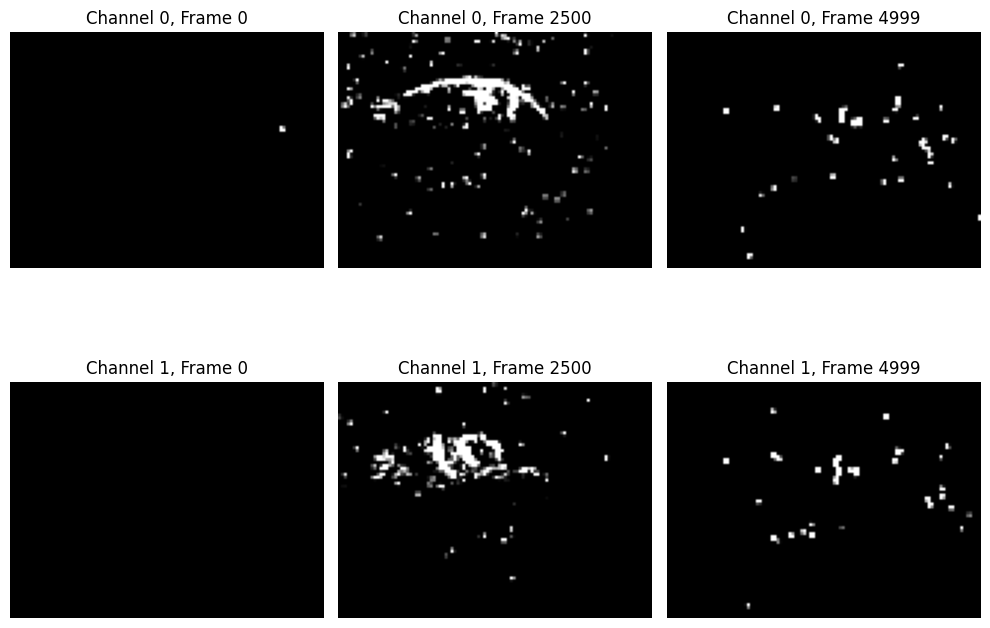

In [40]:
fig, axes = plt.subplots(n_ch, 3, figsize=(10, 4*n_ch))
frame_idxs = [0, n_frames//2, n_frames-1]
for ch in range(n_ch):
    for col, f in enumerate(frame_idxs):
        ax = axes[ch, col] if n_ch > 1 else axes[col]
        im = ax.imshow(data[f, :, :, ch], cmap='gray', 
                       vmin=np.nanmin(data[...,ch]), vmax=np.nanmax(data[...,ch]))
        ax.set_title(f'Channel {ch}, Frame {f}')
        ax.axis('off')
fig.tight_layout()
plt.show()

KeyboardInterrupt: 

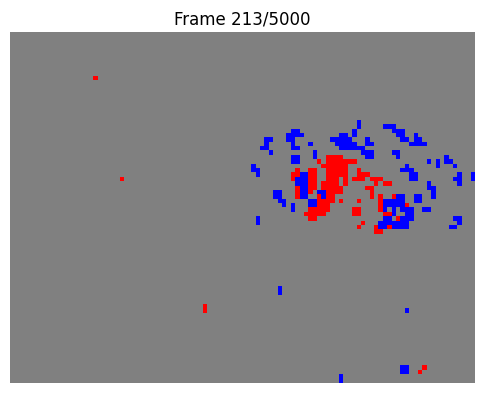

In [43]:
if n_ch == 2:
    # e.g. channel 0 = red, channel 1 = blue
    colors = np.array([[255, 0, 0], [0, 0, 255]], dtype=np.uint8)
else:
    # fallback: pick from matplotlib’s tab10 palette
    import matplotlib
    cmap = matplotlib.cm.get_cmap('tab10', n_ch)
    colors = (cmap(range(n_ch))[:, :3] * 255).astype(np.uint8)

# 3) Create one figure & axis to reuse
fig, ax = plt.subplots(figsize=(6, 6))

# 4) Loop over frames, updating in place
for f in range(n_frames):
    # 4a) start from a mid-gray background
    frame_vis = np.full((H, W, 3), 128, dtype=np.uint8)
    
    # 4b) paint each channel’s “events” on top
    for ch in range(n_ch):
        mask = data[f, :, :, ch] > 0   # assuming >0 marks an event
        print(f"mask.shape: {mask.shape}, frame: {f}, channel: {ch}")
        frame_vis[mask] = colors[ch]
    
    # 4c) update the image
    ax.clear()
    ax.imshow(frame_vis)
    ax.set_title(f'Frame {f+1}/{n_frames}')
    ax.axis('off')
    
    # 4d) redraw the same window
    clear_output(wait=True)
    display(fig)
    time.sleep(0.01)   # adjust playback speed

# 5) close when done
plt.close(fig)

In [44]:
import akida_models
from akida_models.model_io import load_model
model = load_model("models/tenn_spatiotemporal_eye_buffer_i8_w8_a8.fbz")
print(f"Model input shape: {model.input_shape}")

Model input shape: [80, 106, 2]


In [45]:
# Iterate through the 5000 entries in the first dimension
from akida_models.tenn_spatiotemporal.eye_losses import process_detector_prediction  
HEIGHT, WIDTH = 480, 640  # Display size

preds_list = []  
for i in range(data.shape[0]):
    frame = data[i][np.newaxis, :]
    print(f"Processing entry {i} with shape {frame.shape}, dtype = {data[i].dtype}")
    pred = model.predict(frame)
    print(f"prediction shape: {pred.shape}")

    pred = process_detector_prediction(tf.expand_dims(pred, 0))
    print(f"Pred shape after process_detector_prediction : {pred.shape}")

    y_pred_x = pred[:, 1] * W
    y_pred_y = pred[:, 0] * H

    print(f"x pred, y pred : {y_pred_x , y_pred_y}")

    # Convert to NumPy scalars
    cx = int(y_pred_x.numpy().flatten()[0])
    cy = int(y_pred_y.numpy().flatten()[0])
    print(f"x pred, y pred : ({cx}, {cy})")
    
    single_pred = np.array([[cx, cy]], dtype=np.int32)
    preds_list.append(single_pred)

Processing entry 0 with shape (1, 80, 106, 2), dtype = int8
prediction shape: (1, 3, 4, 3)
Pred shape after process_detector_prediction : (1, 2, 1)
x pred, y pred : (<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[18.539955]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[51.636795]], dtype=float32)>)
x pred, y pred : (18, 51)
Processing entry 1 with shape (1, 80, 106, 2), dtype = int8
prediction shape: (1, 3, 4, 3)
Pred shape after process_detector_prediction : (1, 2, 1)
x pred, y pred : (<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[25.017086]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[51.357162]], dtype=float32)>)
x pred, y pred : (25, 51)
Processing entry 2 with shape (1, 80, 106, 2), dtype = int8
prediction shape: (1, 3, 4, 3)
Pred shape after process_detector_prediction : (1, 2, 1)
x pred, y pred : (<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[25.733324]], dtype=float32)>, <tf.Tensor: shape=(1, 1),

In [46]:
print(len(preds_list), "predictions collected.")
print("Shape of preds_list:", np.array(preds_list).shape)
print("First prediction:", preds_list[0])

5000 predictions collected.
Shape of preds_list: (5000, 1, 2)
First prediction: [[18 51]]


KeyboardInterrupt: 

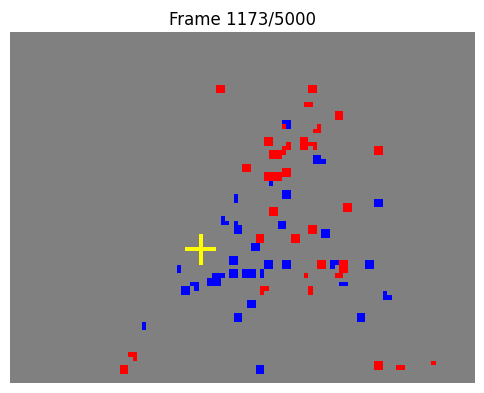

In [51]:
if n_ch == 2:
    # e.g. channel 0 = red, channel 1 = blue
    colors = np.array([[255, 0, 0], [0, 0, 255]], dtype=np.uint8)
else:
    # fallback: pick from matplotlib’s tab10 palette
    import matplotlib
    cmap = matplotlib.cm.get_cmap('tab10', n_ch)
    colors = (cmap(range(n_ch))[:, :3] * 255).astype(np.uint8)

# 3) Create one figure & axis to reuse
fig, ax = plt.subplots(figsize=(6, 6))

# Define the size of the cross
cross_size = 3

# 4) Loop over frames, updating in place
for f in range(n_frames):
    # 4a) start from a mid-gray background
    frame_vis = np.full((H, W, 3), 128, dtype=np.uint8)
    
    # 4b) paint each channel’s “events” on top
    for ch in range(n_ch):
        mask = data[f, :, :, ch] > 0   # assuming >0 marks an event
        print(f"mask: {mask}")
        
        # Create mask for `preds_list` based on values in the third axis
        # Assuming (5000, 1, 2): To get values we need to use [:, :, 1] to access the second element along axis 2
        # Initialize an empty mask for the current frame
        pred_mask = np.zeros((data.shape[1], data.shape[2]), dtype=bool)

        # Get x, y location from other_array for the current frame
        #x, y = preds_list[f, 0, :]
        x, y = preds_list[f][0, :]

        # Draw a cross centered at (x, y)
        for i in range(-cross_size, cross_size + 1):
            if 0 <= x + i < data.shape[1]:
                pred_mask[x + i, y] = True
            if 0 <= y + i < data.shape[2]:
                pred_mask[x, y + i] = True

        # Set the location (x, y) in pred_mask to True
        #pred_mask[int(x), int(y)] = True
        #print(f"frame: {f}, prediction: {preds_list[f]}")

        
        frame_vis[mask] = colors[ch]
        frame_vis[pred_mask] = [255, 255, 0]
    
    # 4c) update the image
    ax.clear()
    ax.imshow(frame_vis)
    ax.set_title(f'Frame {f+1}/{n_frames}')
    ax.axis('off')
    
    # 4d) redraw the same window
    clear_output(wait=True)
    display(fig)
    time.sleep(0.01)   # adjust playback speed

# 5) close when done
plt.close(fig)